# Data Analysis for CREMA-D Embeddings

Exploratory analysis of CREMA-D audio representations. This notebook visualizes raw waveforms and mel-spectrograms, inspects precomputed embeddings (ResNet18, VGG16, PANNs_cnn14), applies PCA, and evaluates lightweight baseline classifiers for selected emotions.
    

In [ ]:
# Setup del entorno: montar Drive y clonar repositorio

# Montar Google Drive para acceder a los datos almacenados en `/content/drive/MyDrive/CREMAD`
from google.colab import drive
drive.mount('/content/drive')

# Clonar el repositorio (si es necesario) y añadir `src` al path
repo_path = '/content/qnn-transfer-learning'
import os
if not os.path.isdir(repo_path):
    %cd /content
    !git clone https://github.com/lburdman/qnn-transfer-learning.git
%cd qnn-transfer-learning

import sys
sys.path.append('src')

Mounted at /content/drive
/content
Cloning into 'qnn-transfer-learning'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 102 (delta 43), reused 78 (delta 20), pack-reused 0 (from 0)
Receiving objects: 100% (102/102), 4.63 MiB | 17.95 MiB/s, done.
Resolving deltas: 100% (43/43), done.
/content/qnn-transfer-learning


In [ ]:
# Imports & configuration
import os
from pathlib import Path
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display

from IPython.display import display

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
try:
    import torch
    torch.manual_seed(SEED)
except ImportError:
    torch = None

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'legend.fontsize': 10
})

DATA_ROOT = Path('/content/drive/MyDrive/CREMAD')
AUDIO_DIR = DATA_ROOT / 'AudioWAV'
SPLITS_DIR = DATA_ROOT / 'splits'
SPEC_DIR = DATA_ROOT / 'Spectrograms'
EMB_ROOT = DATA_ROOT / 'Embeddings'
PANN_DIR = EMB_ROOT / 'PANNs_Cnn14'

TARGET_SR = 22050
N_FFT = 2048
HOP_LENGTH = 512
N_MELS = 128

SELECTED_CLASSES = ['HAP', 'SAD', 'ANG']
SPLITS_TO_USE = ('train',)  # you can add 'val', 'test' if needed
EMBEDDING_PATHS = {
    'resnet18': EMB_ROOT / 'ResNet18',
    'vgg16': EMB_ROOT / 'VGG16',
    'panns_cnn14': PANN_DIR,
}
EMBEDDING_TYPES = list(EMBEDDING_PATHS.keys())
PCA_COMPONENTS_MAX = 50


In [ ]:
# Utility functions for metadata and embedding loading

def load_metadata(selected_classes=SELECTED_CLASSES):
    """
    Load metadata for waveform / mel-spectrogram visualization.

    This still assumes CSV split files exist in SPLITS_DIR (train.csv, val.csv, test.csv)
    with at least the columns: 'file_name' and 'label'.
    If you don't have those, you can comment this out or adapt it to your own structure.
    """
    frames = []
    for split in ['train', 'val', 'test']:
        csv_path = SPLITS_DIR / f'{split}.csv'
        if not csv_path.exists():
            raise FileNotFoundError(f'Missing split file: {csv_path}')
        df = pd.read_csv(csv_path)
        df['split'] = split
        df['file_stem'] = df['file_name'].apply(lambda x: Path(x).stem)
        df['file_path'] = AUDIO_DIR / df['file_name']
        frames.append(df)

    meta = pd.concat(frames, ignore_index=True)
    if selected_classes:
        meta = meta[meta['label'].isin(selected_classes)].reset_index(drop=True)
    return meta


def load_embeddings(embedding_type: str,
                    splits=SPLITS_TO_USE,
                    selected_classes=SELECTED_CLASSES):
    """
    Load embeddings directly from the directory structure:

    Embeddings/
        ResNet18/
            train/
                ANG/
                    xxxx.npy / xxxx.npz
                HAP/
                SAD/
                ...
            val/
            test/
        VGG16/
        PANNs_Cnn14/

    Returns:
        X: np.ndarray, shape (n_samples, n_features)
        y: np.ndarray, shape (n_samples,)
        meta_loaded: pd.DataFrame with columns:
            ['embedding_path', 'split', 'label', 'file_stem']
    """
    base_key = embedding_type.lower()
    if base_key not in EMBEDDING_PATHS:
        raise ValueError(f'Unknown embedding type: {embedding_type}')

    base_dir = EMBEDDING_PATHS[base_key]
    if not base_dir.exists():
        raise FileNotFoundError(f'Embedding directory not found: {base_dir}')

    if isinstance(splits, str):
        splits = (splits,)

    X_list, y_list, records = [], [], []
    load_errors = []

    for split in splits:
        split_dir = base_dir / split
        if not split_dir.exists():
            print(f'[load_embeddings] Split directory not found, skipping: {split_dir}')
            continue

        # Iterate over class folders (ANG, HAP, SAD, etc.)
        for label_dir in sorted(split_dir.iterdir()):
            if not label_dir.is_dir():
                continue

            label = label_dir.name
            if selected_classes and label not in selected_classes:
                continue

            # First look for NPZ, then NPY
            files = list(label_dir.glob('*.npz')) + list(label_dir.glob('*.npy'))
            if not files:
                continue

            for fpath in files:
                try:
                    data = np.load(fpath, allow_pickle=False)
                    if isinstance(data, np.lib.npyio.NpzFile):
                        # Prefer 'embedding' key if present
                        if 'embedding' in data.files:
                            emb = data['embedding']
                        elif data.files:
                            emb = data[data.files[0]]
                        else:
                            raise ValueError('Empty NPZ file')
                    else:
                        emb = data

                    emb = np.asarray(emb)
                    # Ensure 1D feature vector
                    if emb.ndim > 1:
                        emb = emb.reshape(-1)

                    X_list.append(emb)
                    y_list.append(label)
                    records.append({
                        'embedding_path': str(fpath),
                        'split': split,
                        'label': label,
                        'file_stem': fpath.stem,
                    })
                except Exception as e:
                    load_errors.append((str(fpath), repr(e)))
                    continue

    if not X_list:
        raise RuntimeError(f'No embeddings loaded for {embedding_type} with current filters.')

    if load_errors:
        print(f'[load_embeddings] {len(load_errors)} files failed to load for {embedding_type}.')
        print('  Example errors:', load_errors[:3])

    X = np.stack(X_list)
    y = np.array(y_list)
    meta_loaded = pd.DataFrame(records).reset_index(drop=True)
    return X, y, meta_loaded


In [ ]:
# Waveform and mel-spectrogram visualization helpers
def plot_waveform(audio_path, ax=None, sr=TARGET_SR):
    y, sr = librosa.load(audio_path, sr=sr)
    times = np.linspace(0, len(y) / sr, num=len(y))
    ax = ax or plt.gca()
    ax.plot(times, y, color='steelblue', linewidth=0.8)
    ax.set_title(f'Waveform: {Path(audio_path).name}')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Amplitude')
    return ax

def plot_melspectrogram(audio_path, sr=None, ax=None):
    y, sr = librosa.load(audio_path, sr=sr or TARGET_SR)
    mel_spec = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        n_mels=N_MELS
    )
    log_mel = librosa.power_to_db(mel_spec, ref=np.max)
    ax = ax or plt.gca()
    img = librosa.display.specshow(
        log_mel,
        sr=sr,
        hop_length=HOP_LENGTH,
        x_axis='time',
        y_axis='mel',
        ax=ax
    )
    ax.set_title(f'Mel-spectrogram: {Path(audio_path).name}')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Mel frequency bins')
    plt.colorbar(img, ax=ax, format='%+2.0f dB')
    return ax

def plot_example_waveform_and_mel(row):
    audio_path = row['file_path']
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))
    plot_waveform(audio_path, ax=axes[0])
    plot_melspectrogram(audio_path, ax=axes[1])
    fig.suptitle(f"{row['label']} ? {Path(audio_path).name}")
    plt.tight_layout()
    plt.show()


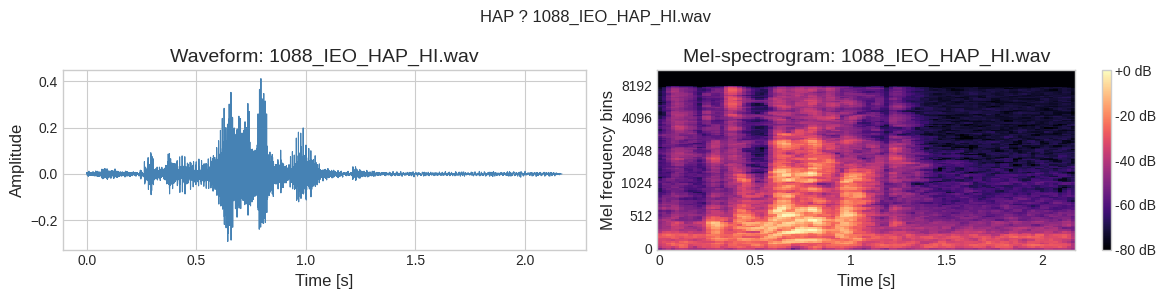

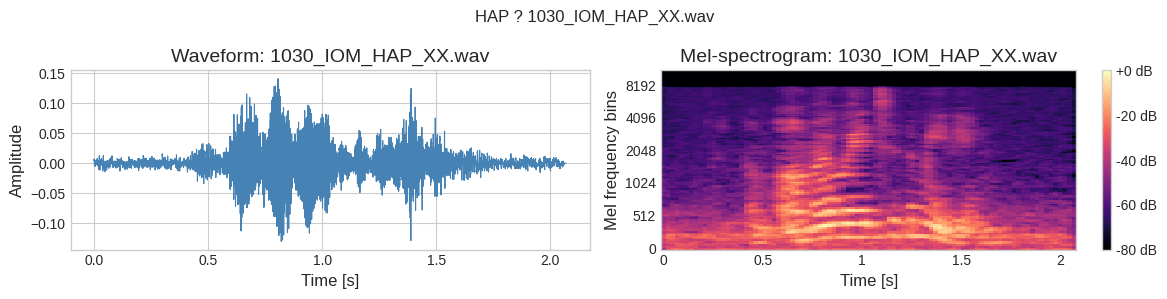

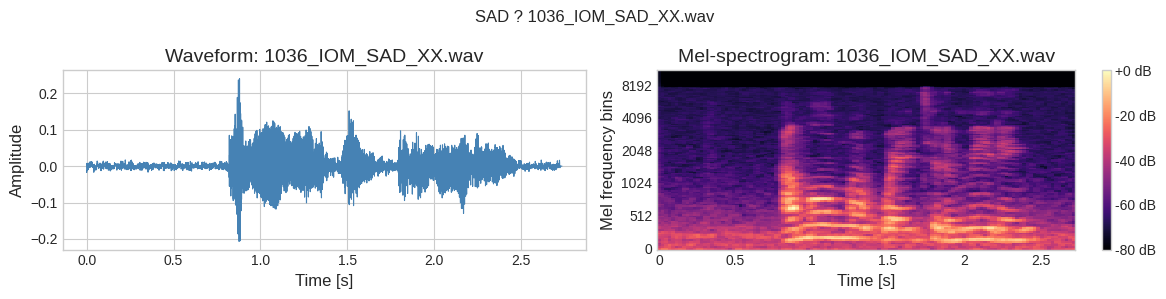

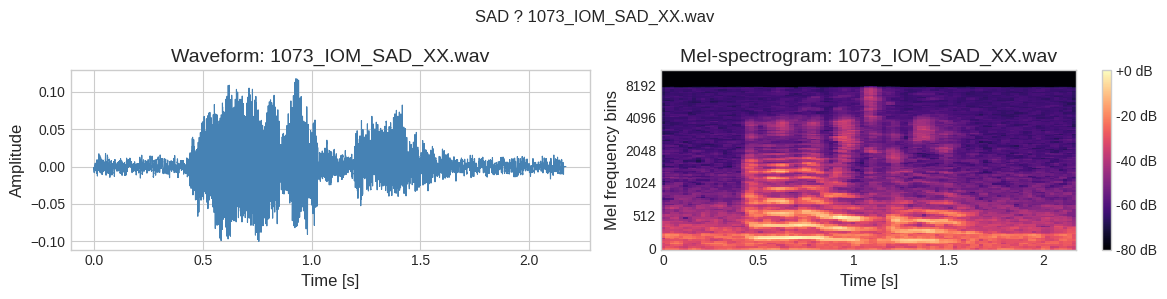

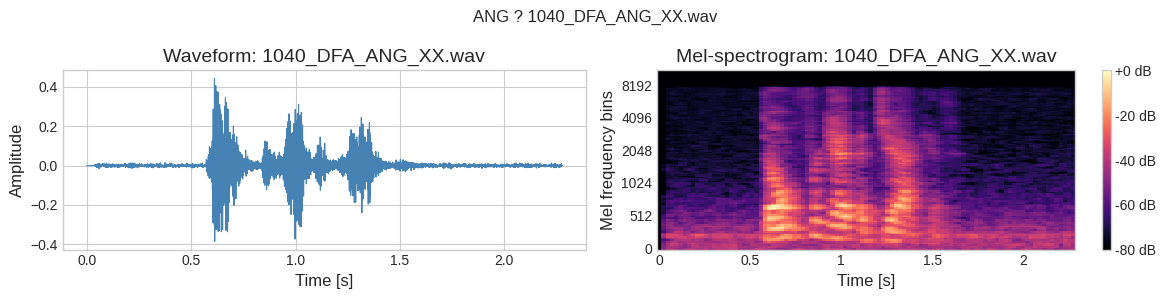

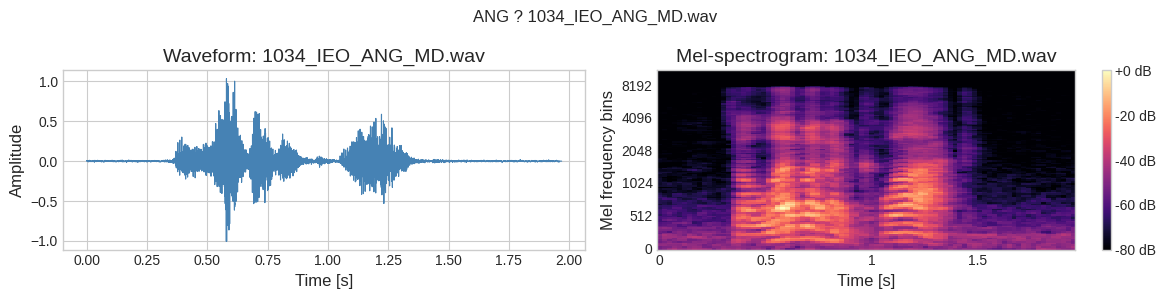

In [ ]:
# Sample examples per class for waveform and mel views
meta_df = load_metadata()
examples = []
for cls in SELECTED_CLASSES:
    cls_df = meta_df[meta_df['label'] == cls]
    if cls_df.empty:
        continue
    n_show = min(2, len(cls_df))
    sampled = cls_df.sample(n=n_show, random_state=SEED)
    examples.append(sampled)

if examples:
    for _, row in pd.concat(examples).iterrows():
        plot_example_waveform_and_mel(row)
else:
    print('No examples available for the selected classes.')



=== resnet18 ===
[load_embeddings] 1 files failed to load for resnet18.
  Example errors: [('/content/drive/MyDrive/CREMAD/Embeddings/ResNet18/train/HAP/1030_IWL_HAP_XX.npz', "EOFError('No data left in file')")]
Samples: 2667 | Embedding dimension: 512
Class distribution:
ANG    890
SAD    889
HAP    888
Name: count, dtype: int64


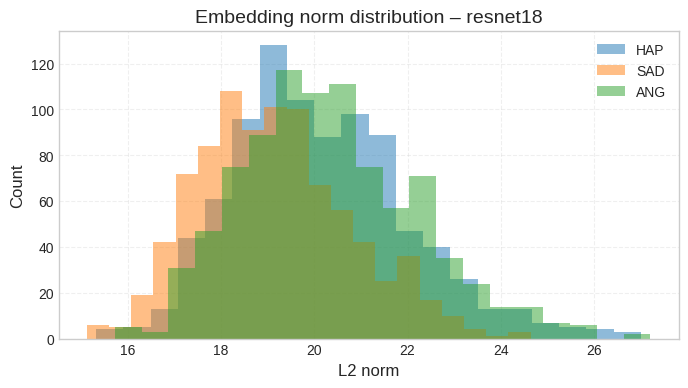

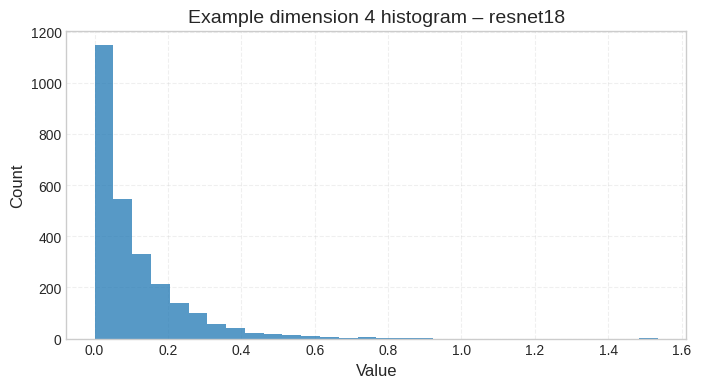


=== vgg16 ===
Samples: 2668 | Embedding dimension: 4096
Class distribution:
ANG    890
HAP    889
SAD    889
Name: count, dtype: int64


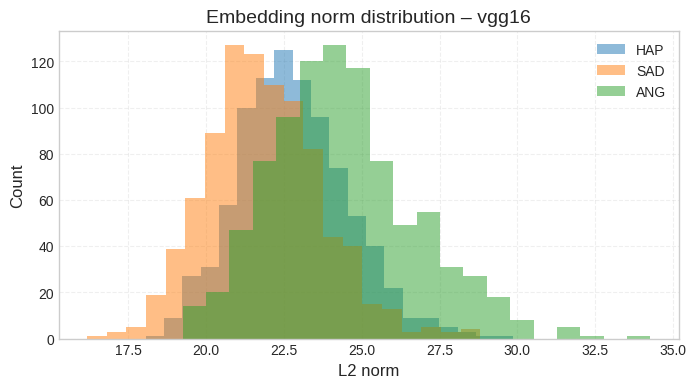

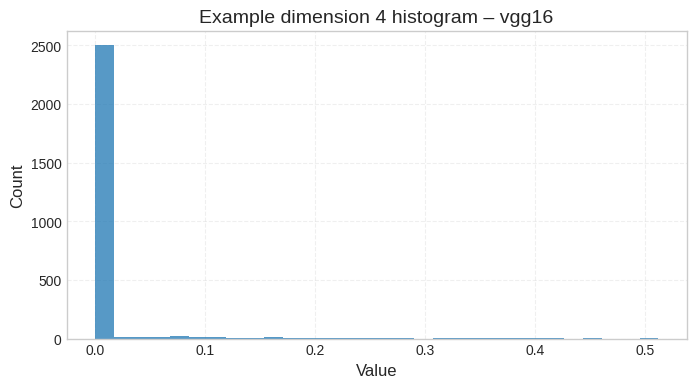


=== panns_cnn14 ===
Samples: 2668 | Embedding dimension: 2048
Class distribution:
ANG    890
HAP    889
SAD    889
Name: count, dtype: int64


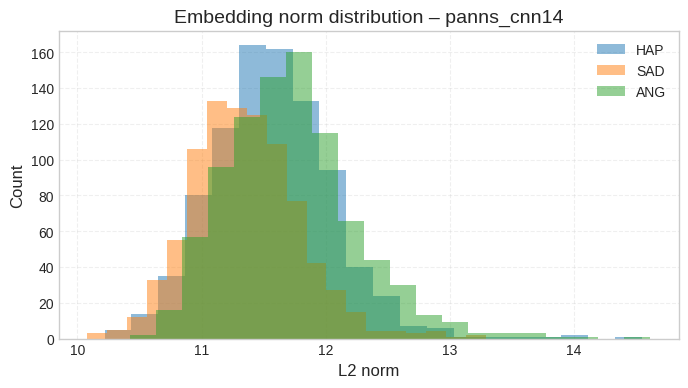

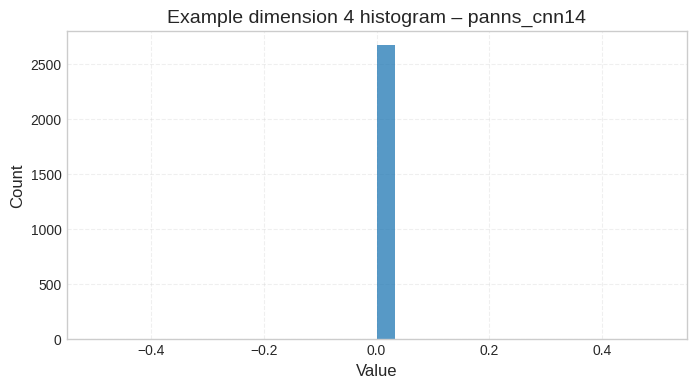

In [ ]:
# Load embeddings and basic statistics
embedding_store = {}

for emb_type in EMBEDDING_TYPES:
    print(f'\n=== {emb_type} ===')
    X, y, meta = load_embeddings(emb_type, splits=SPLITS_TO_USE)
    embedding_store[emb_type] = {'X': X, 'y': y, 'meta': meta}

    print(f'Samples: {len(X)} | Embedding dimension: {X.shape[1]}')
    print('Class distribution:')
    print(pd.Series(y).value_counts())

    # Norm distribution per class
    norms = np.linalg.norm(X, axis=1)
    fig, ax = plt.subplots(figsize=(8, 4))
    for cls in SELECTED_CLASSES:
        mask = (y == cls)
        if mask.any():
            ax.hist(norms[mask], bins=20, alpha=0.5, label=cls)

    ax.set_title(f'Embedding norm distribution – {emb_type}')
    ax.set_xlabel('L2 norm')
    ax.set_ylabel('Count')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.3)
    plt.show()

    # Example histogram of a single embedding dimension
    dim_index = min(4, X.shape[1] - 1)
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.hist(X[:, dim_index], bins=30, alpha=0.75)
    ax.set_title(f'Example dimension {dim_index} histogram – {emb_type}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')
    ax.grid(True, linestyle='--', alpha=0.3)
    plt.show()


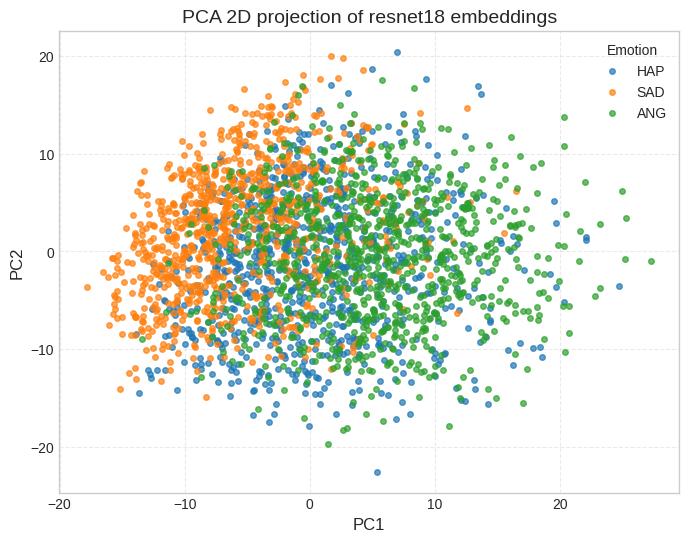

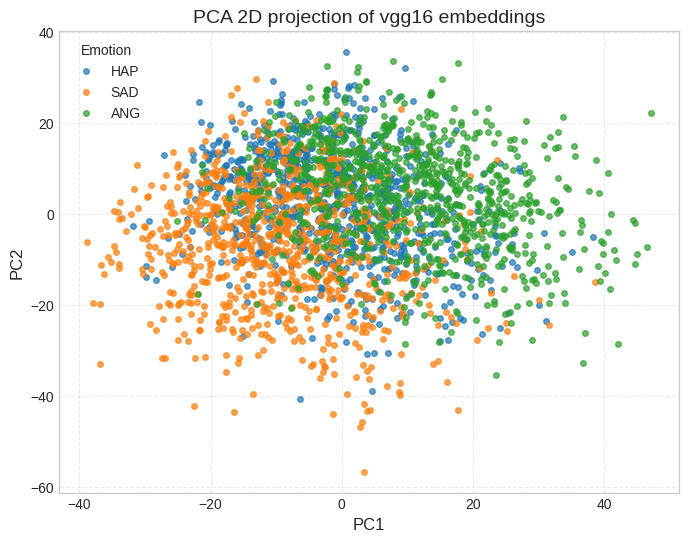

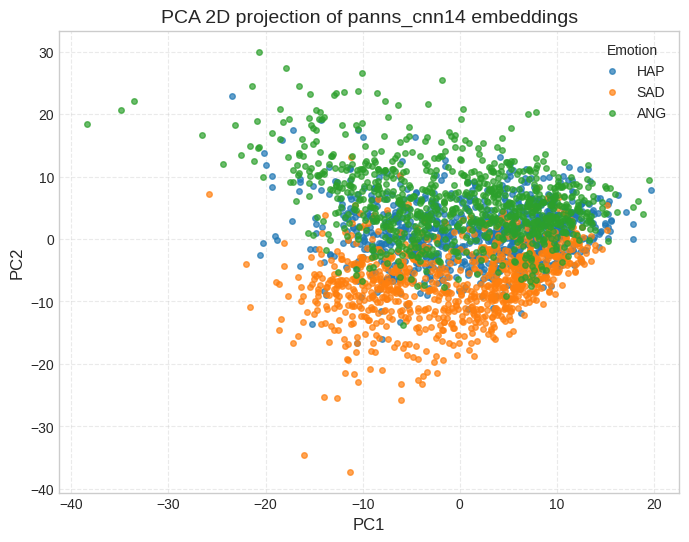

In [ ]:
# PCA 2D projections
pca_results = {}
for emb_type, payload in embedding_store.items():
    X, y = payload['X'], payload['y']
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    n_comp = min(PCA_COMPONENTS_MAX, X_scaled.shape[1], X_scaled.shape[0])
    pca = PCA(n_components=n_comp, random_state=SEED)
    X_pca = pca.fit_transform(X_scaled)
    pca_results[emb_type] = {'pca': pca, 'X_pca': X_pca, 'y': y}

    fig, ax = plt.subplots(figsize=(8, 6))
    for cls in SELECTED_CLASSES:
        mask = y == cls
        if mask.any():
            ax.scatter(X_pca[mask, 0], X_pca[mask, 1], s=16, alpha=0.7, label=cls)
    ax.set_title(f'PCA 2D projection of {emb_type} embeddings')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.legend(title='Emotion')
    ax.grid(True, linestyle='--', alpha=0.4)
    plt.show()


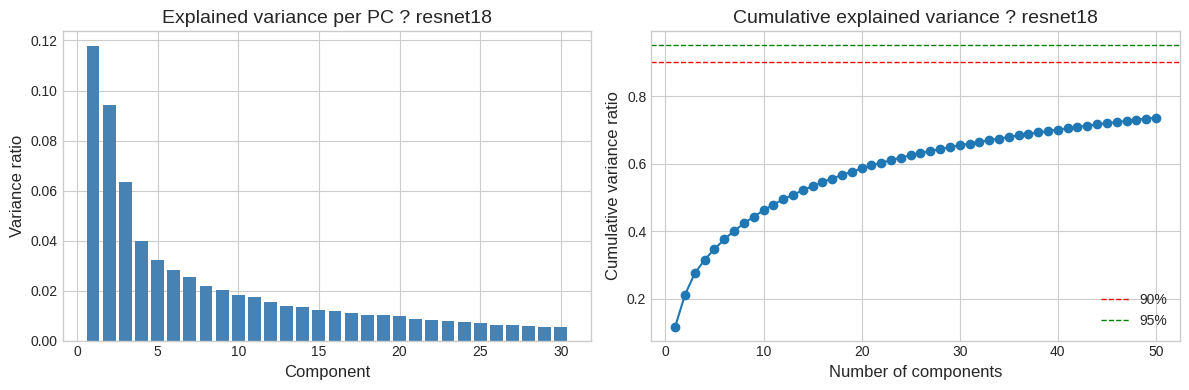

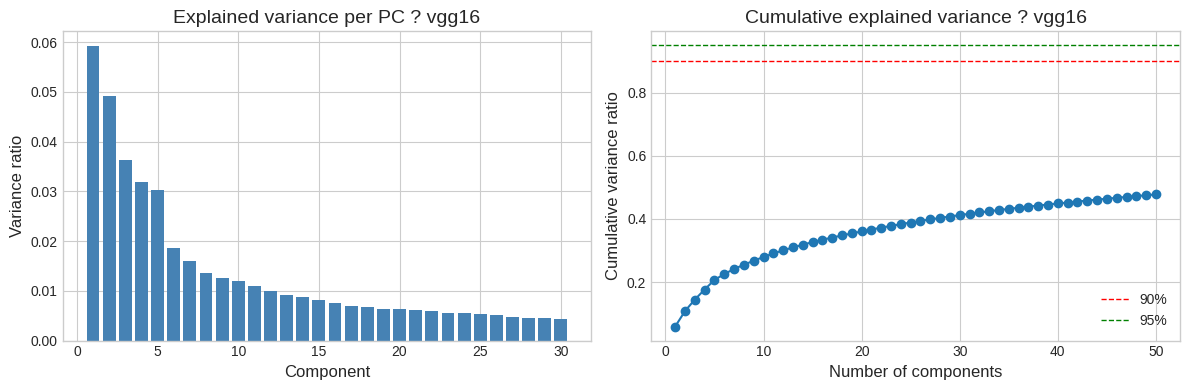

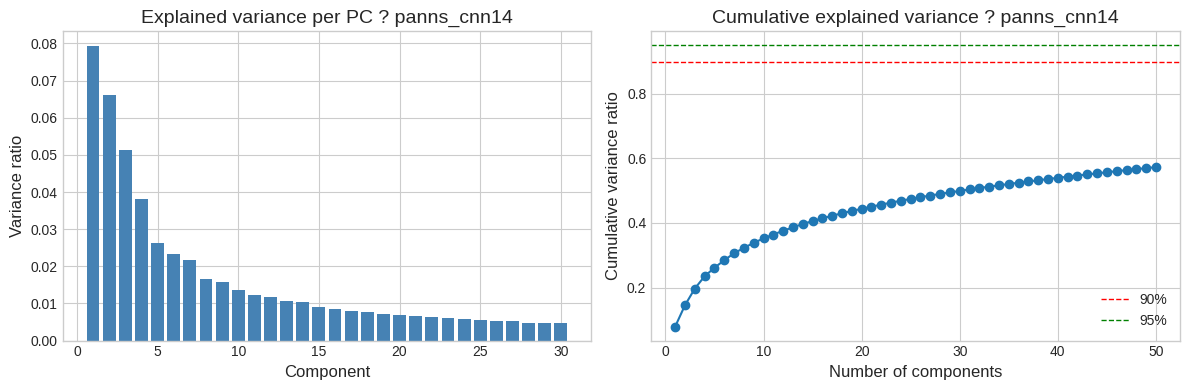

In [ ]:
# Explained variance analysis
for emb_type, res in pca_results.items():
    pca = res['pca']
    evr = pca.explained_variance_ratio_
    cum_evr = np.cumsum(evr)
    k = min(30, len(evr))

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].bar(range(1, k + 1), evr[:k], color='steelblue')
    axes[0].set_title(f'Explained variance per PC ? {emb_type}')
    axes[0].set_xlabel('Component')
    axes[0].set_ylabel('Variance ratio')

    axes[1].plot(range(1, len(cum_evr) + 1), cum_evr, marker='o')
    axes[1].axhline(0.9, color='red', linestyle='--', linewidth=1, label='90%')
    axes[1].axhline(0.95, color='green', linestyle='--', linewidth=1, label='95%')
    axes[1].set_title(f'Cumulative explained variance ? {emb_type}')
    axes[1].set_xlabel('Number of components')
    axes[1].set_ylabel('Cumulative variance ratio')
    axes[1].legend()

    plt.tight_layout()
    plt.show()


In [ ]:
# Baseline classifiers on embeddings
def plot_confusion_matrix(cm, labels, title):
    fig, ax = plt.subplots(figsize=(5, 4))
    im = ax.matshow(cm, cmap='Blues')
    fig.colorbar(im, ax=ax)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='left')
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels(labels)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(title)
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, int(val), ha='center', va='center', color='black', fontsize=9)
    plt.tight_layout()
    return fig

def run_baseline_classifiers(X_train, y_train, X_test, y_test, label_order):
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    models = {
        'Logistic Regression': LogisticRegression(max_iter=500, multi_class='auto', n_jobs=-1, random_state=SEED),
        'Perceptron': Perceptron(max_iter=500, random_state=SEED),
        'MLP (64,)': MLPClassifier(hidden_layer_sizes=(64,), max_iter=150, alpha=1e-4, random_state=SEED)
    }

    rows = []
    for name, clf in models.items():
        clf.fit(X_train_s, y_train)
        preds = clf.predict(X_test_s)
        acc = float((preds == y_test).mean())
        rows.append({'model': name, 'accuracy': acc})
        print(f'=== {name} ===')
        print(f'Accuracy: {acc:.3f}')
        print(classification_report(y_test, preds, labels=label_order))
        cm = confusion_matrix(y_test, preds, labels=label_order)
        plot_confusion_matrix(cm, label_order, title=f'{name} confusion matrix')
        plt.show()
    return pd.DataFrame(rows)


>>> Baselines for resnet18
[load_embeddings] 1 files failed to load for resnet18.
  Example errors: [('/content/drive/MyDrive/CREMAD/Embeddings/ResNet18/train/HAP/1030_IWL_HAP_XX.npz', "EOFError('No data left in file')")]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Logistic Regression ===
Accuracy: 0.716
              precision    recall  f1-score   support

         HAP       0.63      0.60      0.62       255
         SAD       0.80      0.82      0.81       254
         ANG       0.71      0.72      0.71       254

    accuracy                           0.72       763
   macro avg       0.71      0.72      0.71       763
weighted avg       0.71      0.72      0.71       763



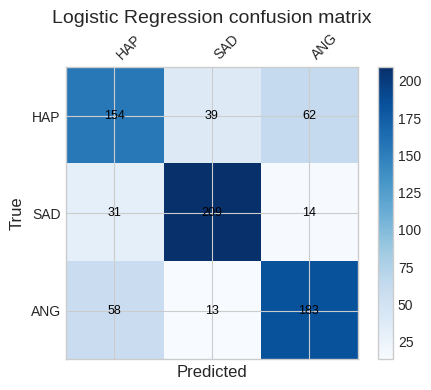

=== Perceptron ===
Accuracy: 0.718
              precision    recall  f1-score   support

         HAP       0.63      0.57      0.60       255
         SAD       0.82      0.86      0.84       254
         ANG       0.69      0.72      0.71       254

    accuracy                           0.72       763
   macro avg       0.71      0.72      0.72       763
weighted avg       0.71      0.72      0.72       763



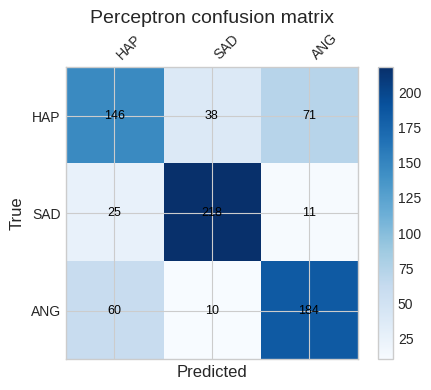

=== MLP (64,) ===
Accuracy: 0.751
              precision    recall  f1-score   support

         HAP       0.68      0.65      0.66       255
         SAD       0.85      0.85      0.85       254
         ANG       0.72      0.75      0.74       254

    accuracy                           0.75       763
   macro avg       0.75      0.75      0.75       763
weighted avg       0.75      0.75      0.75       763



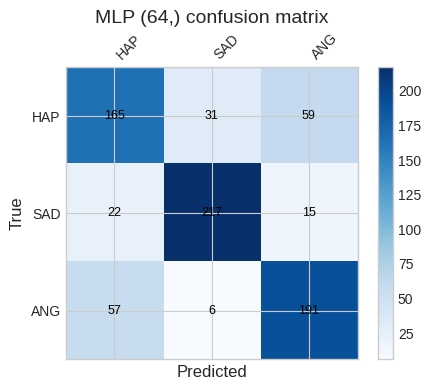

,model,accuracy
0,Logistic Regression,0.715596
1,Perceptron,0.718218
2,"MLP (64,)",0.750983


>>> Baselines for vgg16


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Logistic Regression ===
Accuracy: 0.695
              precision    recall  f1-score   support

         HAP       0.59      0.60      0.59       255
         SAD       0.82      0.81      0.82       254
         ANG       0.68      0.67      0.68       254

    accuracy                           0.69       763
   macro avg       0.70      0.69      0.70       763
weighted avg       0.70      0.69      0.70       763



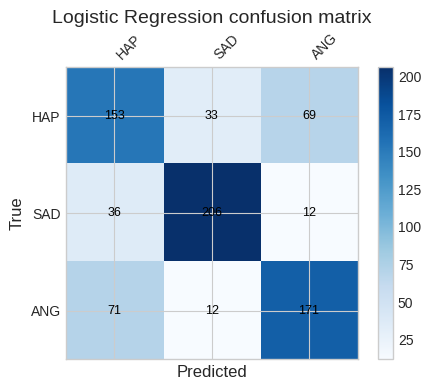

=== Perceptron ===
Accuracy: 0.689
              precision    recall  f1-score   support

         HAP       0.59      0.58      0.58       255
         SAD       0.81      0.79      0.80       254
         ANG       0.67      0.70      0.69       254

    accuracy                           0.69       763
   macro avg       0.69      0.69      0.69       763
weighted avg       0.69      0.69      0.69       763



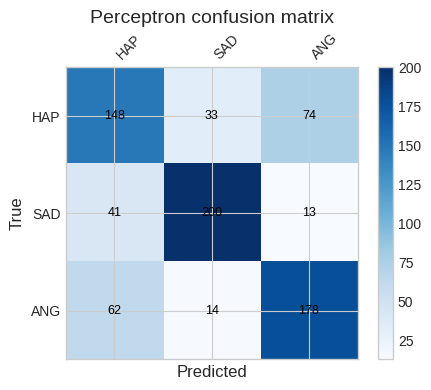

=== MLP (64,) ===
Accuracy: 0.705
              precision    recall  f1-score   support

         HAP       0.61      0.58      0.59       255
         SAD       0.80      0.83      0.81       254
         ANG       0.70      0.71      0.71       254

    accuracy                           0.71       763
   macro avg       0.70      0.71      0.70       763
weighted avg       0.70      0.71      0.70       763



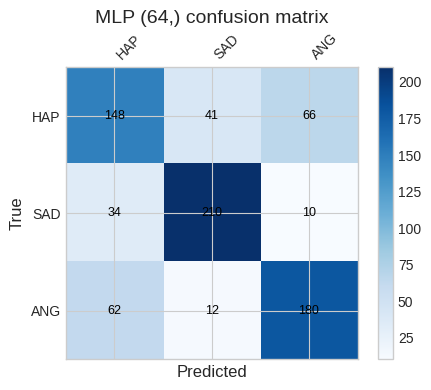

,model,accuracy
0,Logistic Regression,0.694626
1,Perceptron,0.689384
2,"MLP (64,)",0.705111


>>> Baselines for panns_cnn14


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Logistic Regression ===
Accuracy: 0.680
              precision    recall  f1-score   support

         HAP       0.58      0.59      0.58       255
         SAD       0.80      0.79      0.79       254
         ANG       0.66      0.67      0.66       254

    accuracy                           0.68       763
   macro avg       0.68      0.68      0.68       763
weighted avg       0.68      0.68      0.68       763



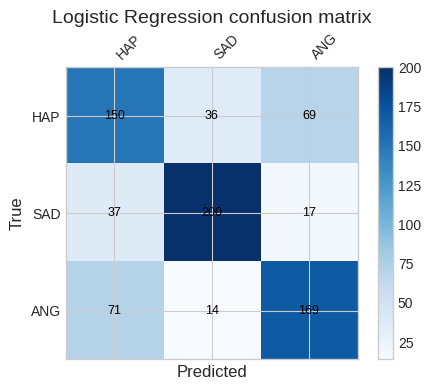

=== Perceptron ===
Accuracy: 0.688
              precision    recall  f1-score   support

         HAP       0.58      0.62      0.60       255
         SAD       0.78      0.82      0.80       254
         ANG       0.71      0.63      0.67       254

    accuracy                           0.69       763
   macro avg       0.69      0.69      0.69       763
weighted avg       0.69      0.69      0.69       763



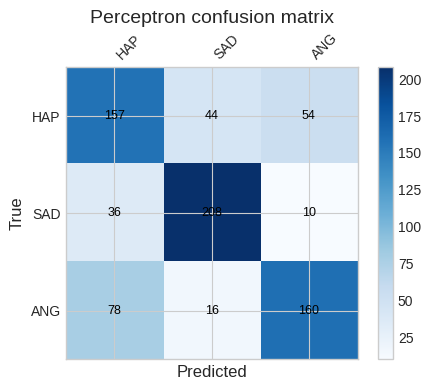

=== MLP (64,) ===
Accuracy: 0.746
              precision    recall  f1-score   support

         HAP       0.66      0.65      0.65       255
         SAD       0.85      0.83      0.84       254
         ANG       0.73      0.76      0.75       254

    accuracy                           0.75       763
   macro avg       0.75      0.75      0.75       763
weighted avg       0.75      0.75      0.75       763



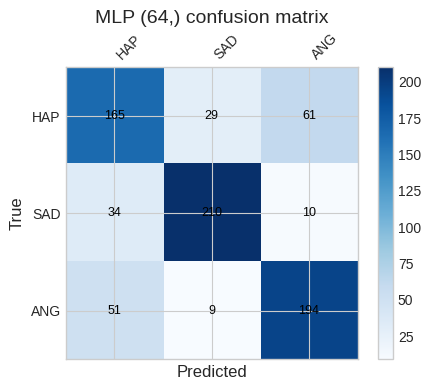

,model,accuracy
0,Logistic Regression,0.680210
1,Perceptron,0.688073
2,"MLP (64,)",0.745740


In [ ]:
# Run baselines for each embedding type
baseline_results = {}
for emb_type in EMBEDDING_TYPES:
    print(f'>>> Baselines for {emb_type}')
    X_train, y_train, _ = load_embeddings(emb_type, splits=['train'])
    X_test, y_test, _ = load_embeddings(emb_type, splits=['test'])
    results_df = run_baseline_classifiers(X_train, y_train, X_test, y_test, SELECTED_CLASSES)
    baseline_results[emb_type] = results_df
    display(results_df)


## Summary

- Embedding dimensionalities, PCA coverage, and baseline accuracies above provide a quick sanity check before hybrid models.
- Components needed for 90?95% variance guide downstream dimensionality reduction choices.
- Visual separability in PCA 2D often correlates with how well classical baselines perform on the selected emotions.
    